In [17]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [3]:
import torch
print(torch.__version__)

1.12.1+cu113


In [1]:
!nvcc --version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [8]:
!pip install mmcv==2.1.0 -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12/index.html


In [32]:
%cd /home/phanthc/Chi/Code/CSAWS-Segment

/home/phanthc/Chi/Code/CSAWS-Segment


In [33]:
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 16493, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 16493 (delta 68), reused 116 (delta 65), pack-reused 16328
Receiving objects: 100% (16493/16493), 43.86 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (11451/11451), done.
Updating files: 100% (1784/1784), done.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from PIL import Image
import skimage
from torch.utils.data.sampler import SubsetRandomSampler

/home/phanthc/miniforge3/envs/csaws-segment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
img_path = r"D:\CHI\2_RESEARCH\Research\BreastCancer\Data\CSAW-S\CSAWS_Sample\original_images\000_0.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

nipple_mask_path = r"D:\CHI\2_RESEARCH\Research\BreastCancer\Data\CsawS\anonymized_dataset\012\012_1_nipple.png"
nipple_mask = cv2.imread(nipple_mask_path, cv2.IMREAD_GRAYSCALE)

pectoral_mask_path = r"D:\CHI\2_RESEARCH\Research\BreastCancer\Data\CsawS\anonymized_dataset\012\012_1_pectoral_muscle.png"
pectoral_mask = cv2.imread(pectoral_mask_path, cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(nipple_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pectoral_mask, cmap='gray')
plt.axis('off')
plt.show()

In [29]:
def OwnGlobalBinarise(img, thresh, maxval):
    
    '''
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.
        
        
    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    '''
    
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    
    return binarised_img

Text(0.5, 1.0, 'Binarised')

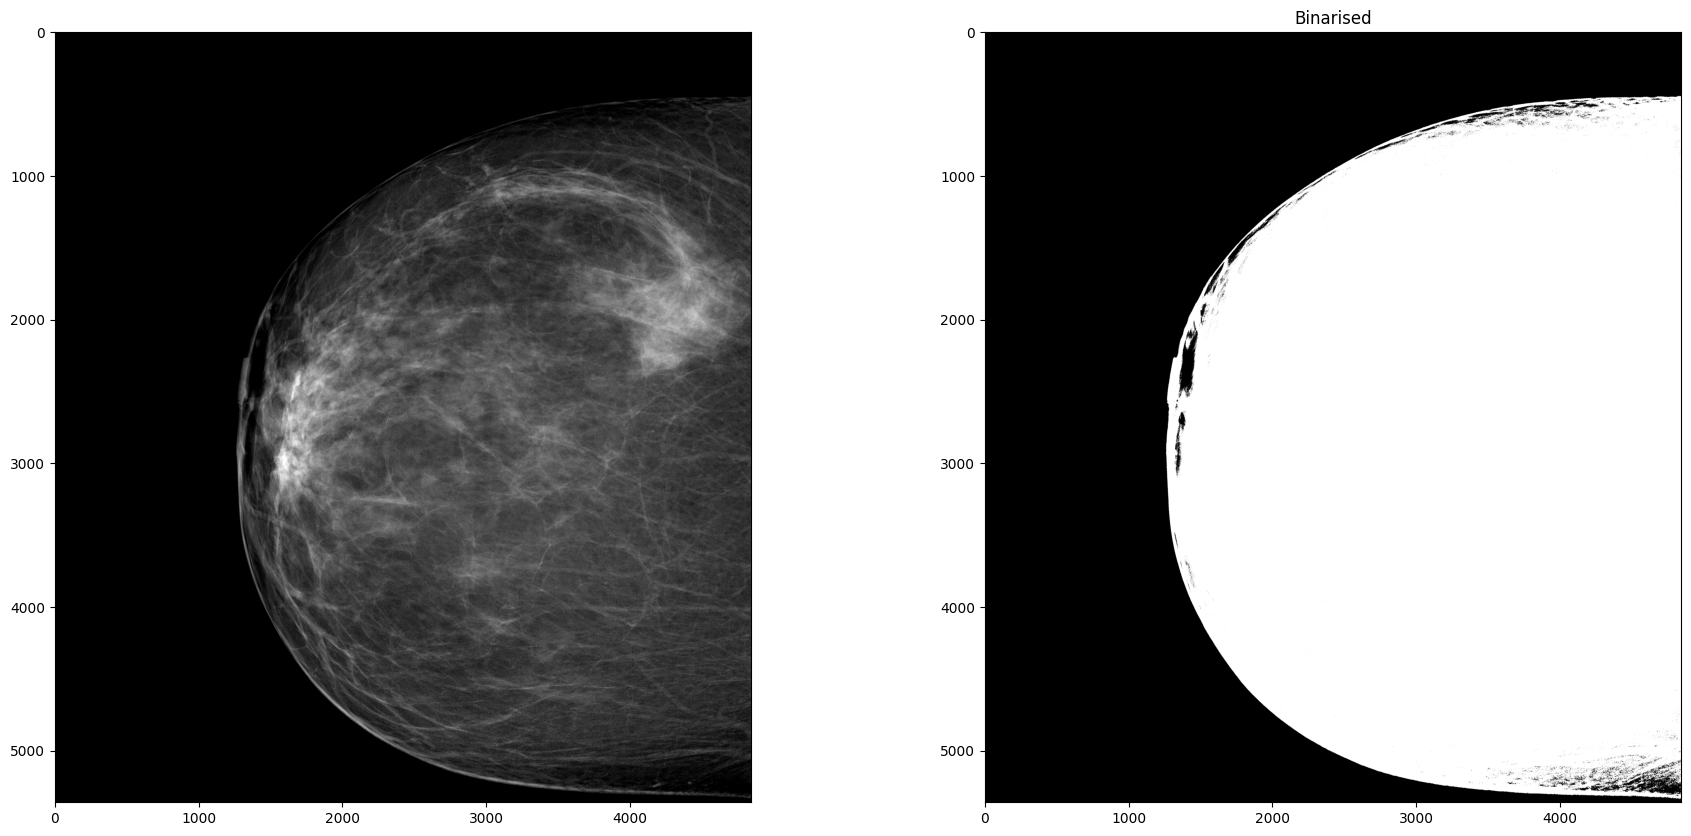

In [30]:
own_binarised_img_list = []

# Plot binarised images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))


ax[0].imshow(img, cmap="gray")

# Plot own binarised image.
binarised_img = OwnGlobalBinarise(img, thresh=0.1, maxval=1.0)
own_binarised_img_list.append(binarised_img)
ax[1].imshow(binarised_img, cmap="gray")
ax[1].set_title("Binarised")

In [31]:
def OpenMask(mask, ksize=(23, 23), operation="open"):

    '''
    This function edits a given mask (binary image) by performing
    closing then opening morphological operations.
    
    Parameters
    ----------
    mask : {numpy.ndarray}
        The mask to edit.
        
    Returns
    -------
    edited_mask : {numpy.ndarray}
        The mask after performing close and open morphological
        operations.
    '''
        
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    
    return edited_mask

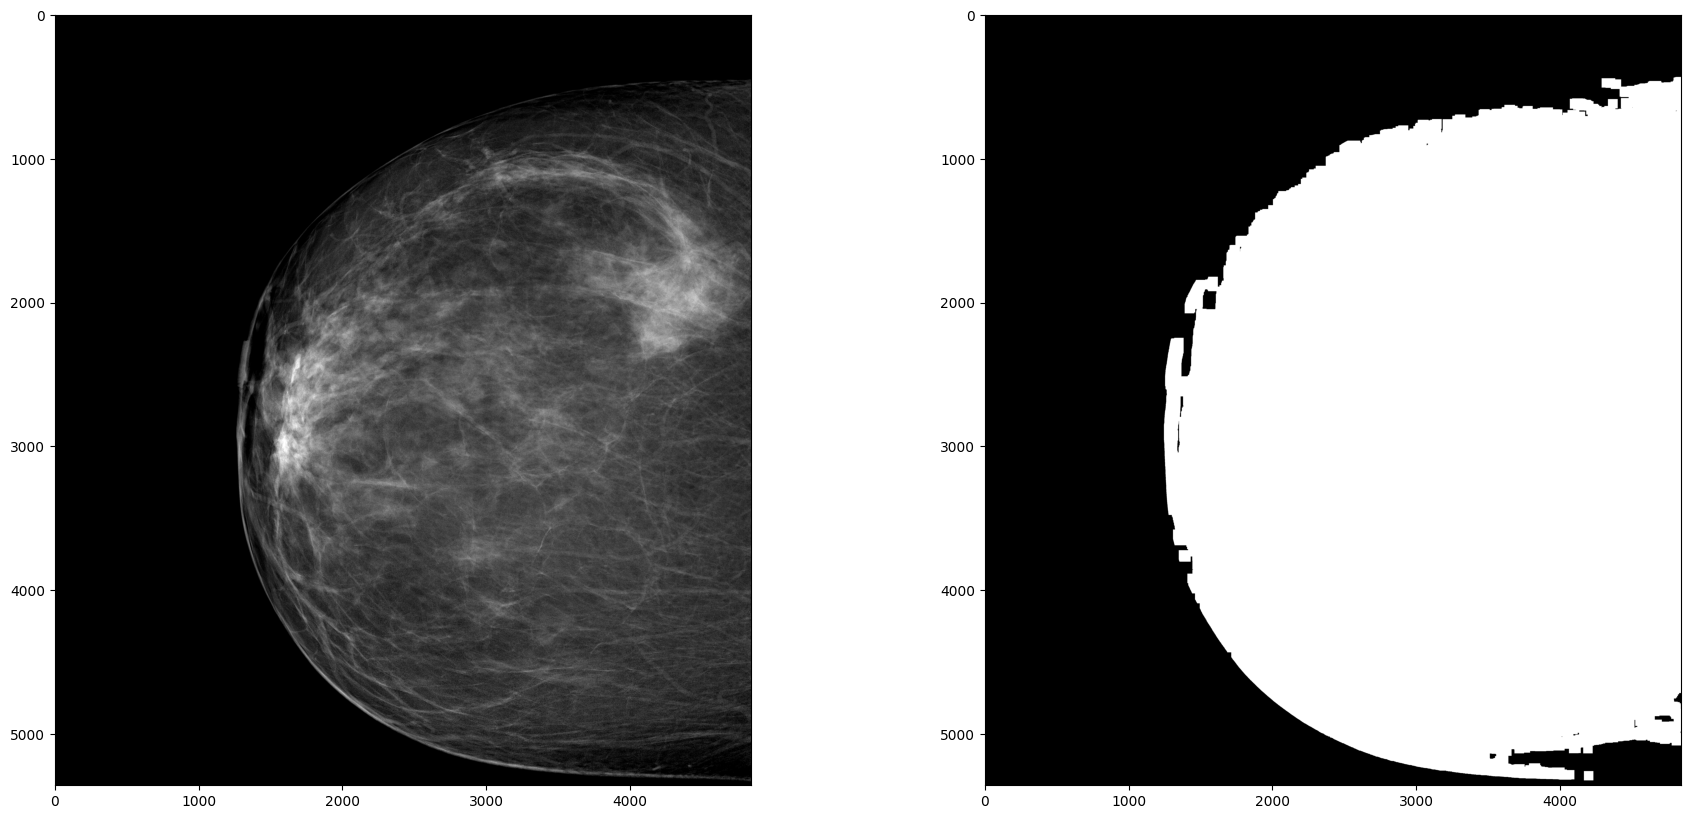

In [32]:
edited_mask_list = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax[0].imshow(img, cmap="gray")
edited_mask = OpenMask(mask=own_binarised_img_list[0], ksize=(33, 33), operation="open")
edited_mask_list.append(edited_mask)
ax[1].imshow(edited_mask, cmap="gray")

In [11]:
def SortContoursByArea(contours, reverse=True):
    
    '''
    This function takes in list of contours, sorts them based
    on contour area, computes the bounding rectangle for each
    contour, and outputs the sorted contours and their
    corresponding bounding rectangles.
    
    Parameters
    ----------
    contours : {list}
        The list of contours to sort.
        
    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    '''
    
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    
    return sorted_contours, bounding_boxes

In [12]:
def DrawContourID(img, bounding_box, contour_id):
    
    '''
    This function draws the given contour and its ID on the given
    image. The image with the drawn contour is returned.
    
    Parameters
    ----------
    img: {numpy.ndarray}
        The image to draw the contour on.
    bounding_box : {tuple of int}
        The bounding_rect of the given contour.
    contour_id : {int or float}
        The corresponding ID of the given `contour`.
        
    Returns
    -------
    img : {numpy.ndarray}
        The image after the `contour` and its ID is drawn on.
    '''
    
    # Center of bounding_rect.
    x, y, w, h = bounding_box
    center = ( ((x + w) // 2), ((y + h) // 2) )
    
    # Draw the countour number on the image
    cv2.putText(img=img,
                text=f"{contour_id}",
                org=center, # Bottom-left corner of the text string in the image.
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=10, 
                color=(255, 255, 255),
                thickness=40)

    return img

In [33]:
def XLargestBlobs(mask, top_X=None):
    
    '''
    This function finds contours in the given image and
    keeps only the top X largest ones.
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_X : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.
        
        
    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    '''
        
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(image=mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    
    n_contours = len(contours)
    
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:
        
        # Make sure that the number of contours to keep is at most equal 
        # to the number of contours present in the mask.
        if n_contours < top_X or top_X == None:
            top_X = n_contours
        
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = SortContoursByArea(contours=contours,
                                                             reverse=True)
        
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_X]
        
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)
        
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(image=to_draw_on, # Draw the contours on `to_draw_on`.
                                           contours=X_largest_contours, # List of contours to draw.
                                           contourIdx=-1, # Draw all contours in `contours`.
                                           color=1, # Draw the contours in white.
                                           thickness=-1) # Thickness of the contour lines.
        
    return n_contours, X_largest_blobs

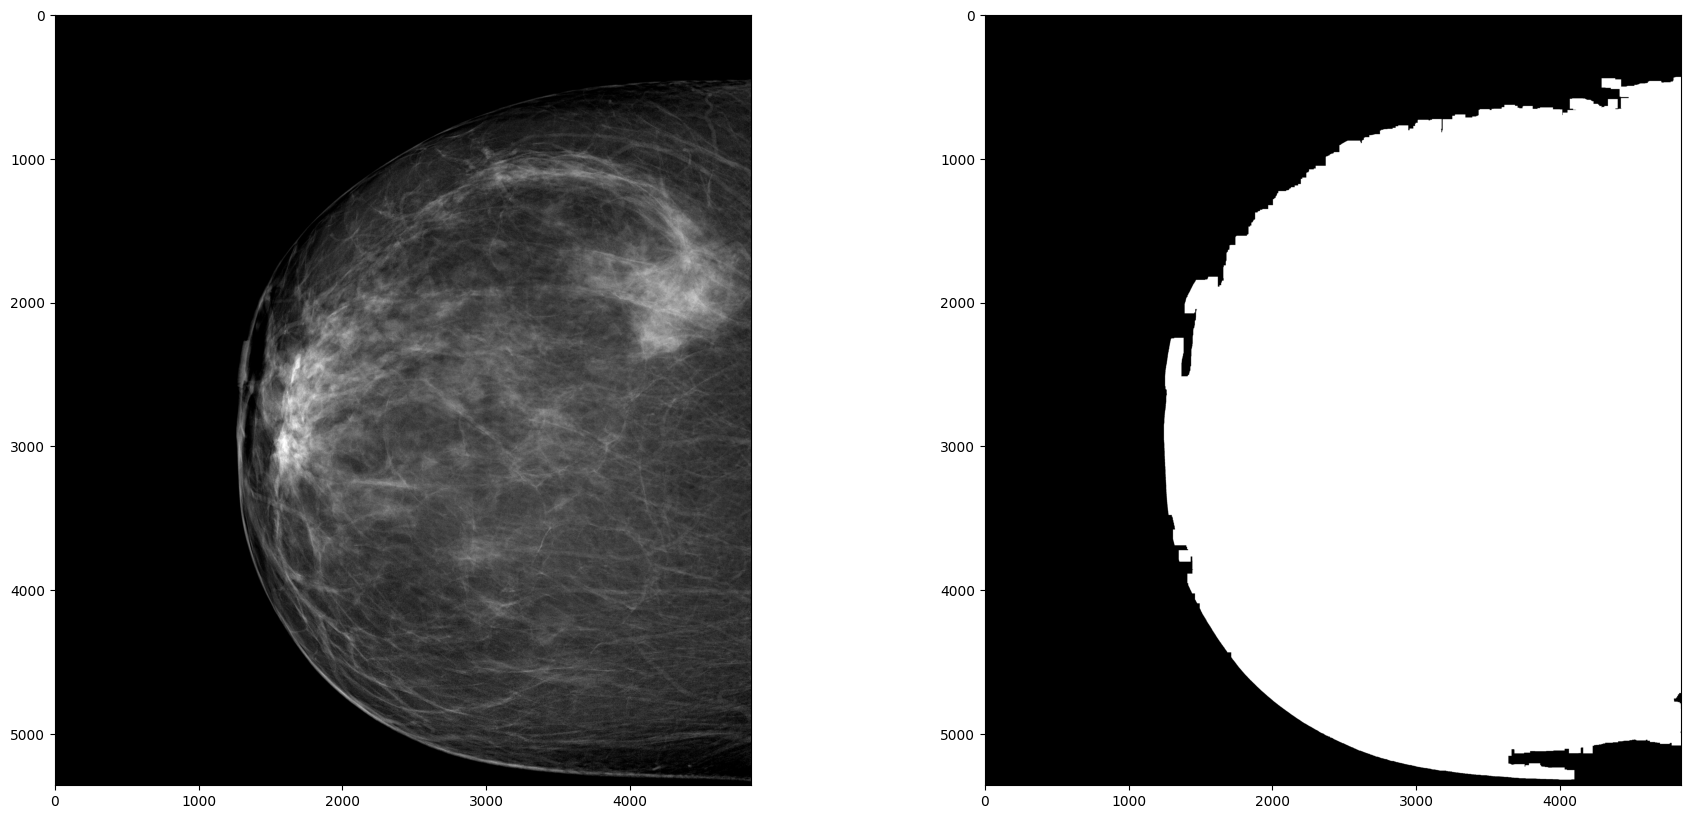

In [34]:
X_largest_blobs_list = []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
ax[0].imshow(img, cmap="gray")
_, X_largest_blobs = XLargestBlobs(mask=edited_mask_list[0], top_X=1)
X_largest_blobs_list.append(X_largest_blobs)
ax[1].imshow(X_largest_blobs, cmap="gray")


In [15]:
def InvertMask(mask):
    
    '''
    This function inverts a given mask (i.e. 0 -> 1
    and 1 -> 0).
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to invert.
        
    Returns
    -------
    inverted_mask: {numpy.ndarray}
        The inverted mask.
    '''
    
    inverted_mask = np.zeros(mask.shape, np.uint8)
    inverted_mask[mask == 0] = 1
    
    return inverted_mask

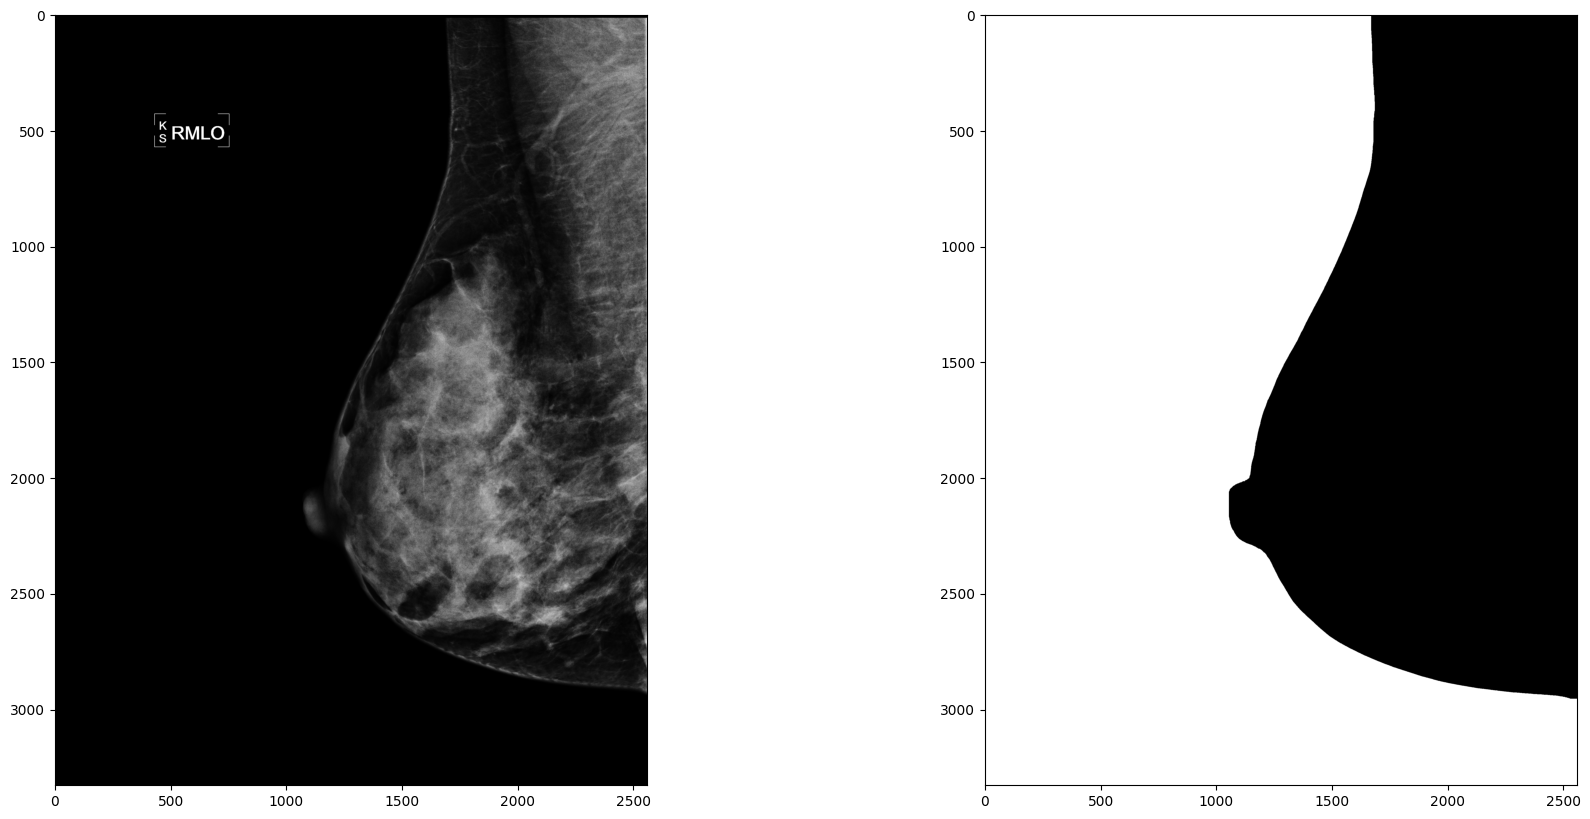

In [16]:
inverted_mask_list = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
ax[0].imshow(img, cmap="gray")
inverted_mask = InvertMask(mask=X_largest_blobs_list[0])
inverted_mask_list.append(inverted_mask)
ax[1].imshow(inverted_mask, cmap="gray")


In [25]:
def InPaint(img, mask, flags="telea", inpaintRadius=30):

    '''
    This function restores an input image in areas indicated
    by the given mask (elements with 1 are restored). 
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to restore.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask that indicates where (elements == 1) in the
        `img` the damage is.
    inpaintRadius : {int}
        Radius of a circular neighborhood of each point
        inpainted that is considered by the algorithm.
        
    Returns
    -------
    inpainted_img: {numpy.ndarray}
        The restored image.
    '''
    
    # First convert to `img` from float64 to uint8.
    img = 255 * img
    img = img.astype(np.uint8)
    
    # Then inpaint based on flags.
    if flags == "telea":
        inpainted_img = cv2.inpaint(src=img,
                                    inpaintMask=mask,
                                    inpaintRadius=inpaintRadius,
                                    flags=cv2.INPAINT_TELEA)
    elif flags == "ns":
        inpainted_img = cv2.inpaint(src=img,
                                    inpaintMask=mask,
                                    inpaintRadius=inpaintRadius,
                                    flags=cv2.INPAINT_NS)
    
    return inpainted_img

In [99]:

inpainted_img_telea_list = []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
ax[0].imshow(img, cmap="gray")
inpainted_img_telea = InPaint(img=img, mask=inverted_mask_list[0], flags="telea", inpaintRadius=30)
inpainted_img_telea_list.append(inpainted_img_telea)
ax[1].imshow(inpainted_img_telea, cmap="gray")

In [26]:
inpainted_img_ns_list = []
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(22, 10))
ax[0].imshow(img, cmap="gray")

ax[1].imshow(own_binarised_img_list[0], cmap="gray")
ax[2].imshow(edited_mask_list[0], cmap="gray")
ax[3].imshow(X_largest_blobs_list[0], cmap="gray")
ax[4].imshow(inverted_mask_list[0], cmap="gray")
inpainted_img_ns = InPaint(img=img, mask=inverted_mask_list[0], flags="ns", inpaintRadius=30)
inpainted_img_ns_list.append(inpainted_img_ns)
ax[5].imshow(inpainted_img_ns, cmap="gray")


In [35]:
def ApplyMask(img, mask):
    
    '''
    This function applies a mask to a given image. White
    areas of the mask are kept, while black areas are
    removed.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.
        
    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    '''
    
    masked_img = img.copy()
    masked_img[mask == 0] = 0
    
    return masked_img

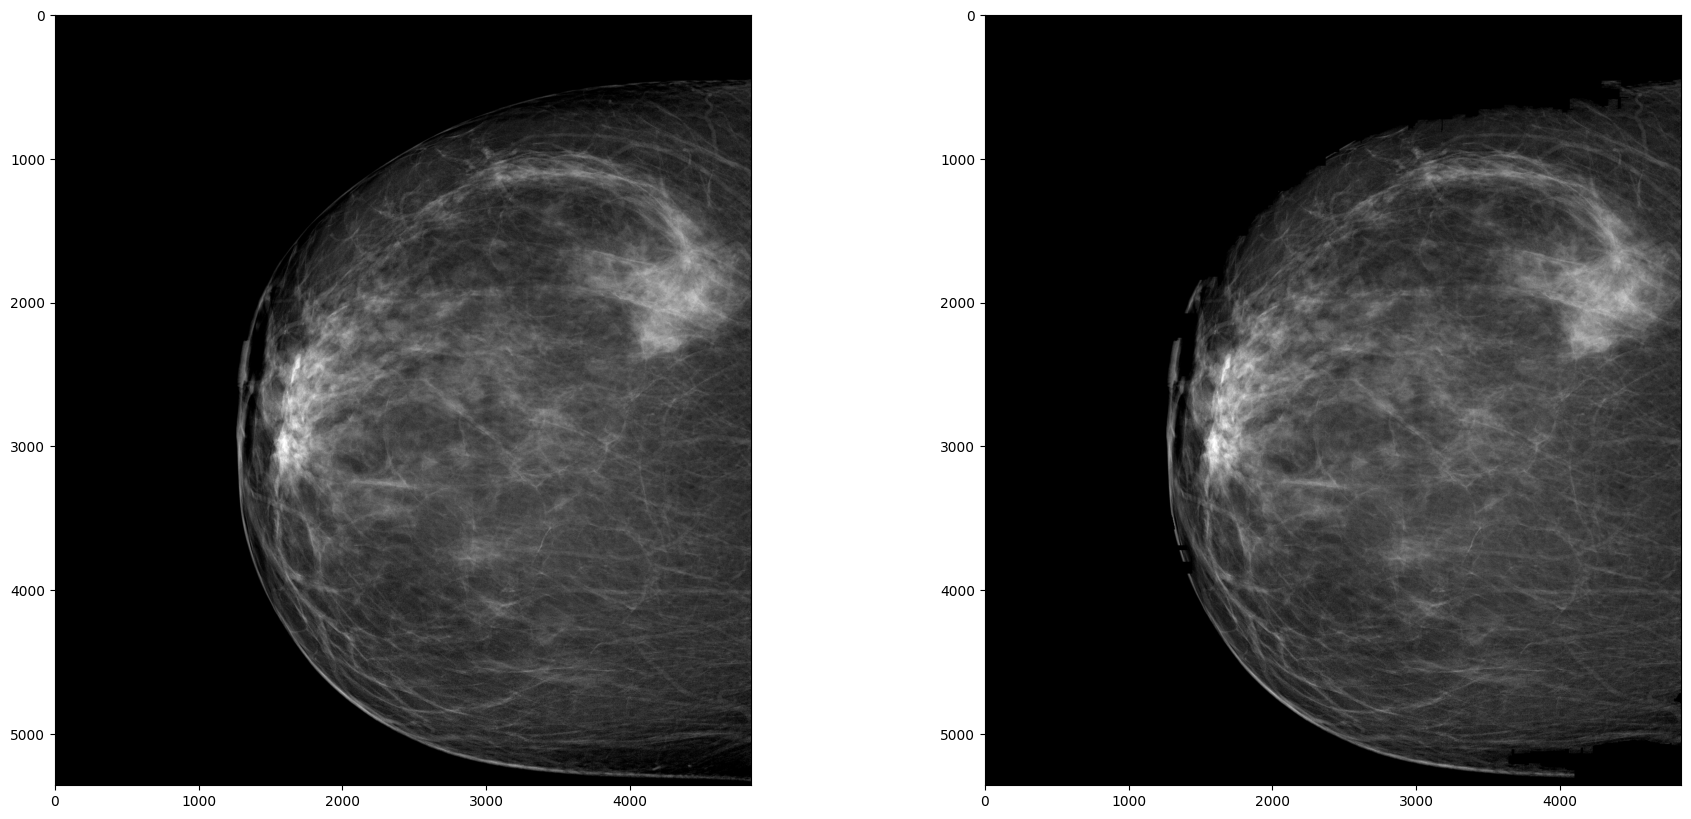

In [36]:
own_masked_img_list = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
ax[0].imshow(img, cmap="gray")
masked_img = ApplyMask(img=img, mask=X_largest_blobs_list[0])
own_masked_img_list.append(masked_img)
ax[1].imshow(masked_img, cmap="gray")



In [19]:
def clahe(img, clip=2.0, tile=(8, 8)):
    
    '''
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to edit.
    clip : {int or floa}
        Threshold for contrast limiting.
    tile : {tuple (int, int)}
        Size of grid for histogram equalization. Input
        image will be divided into equally sized
        rectangular tiles. `tile` defines the number of
        tiles in row and column.
    
    Returns
    -------
    clahe_img : {numpy.ndarray}
        The edited image.
    '''
    
    # Convert to uint8.
    # img = skimage.img_as_ubyte(img)
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")

    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)

    return clahe_img

NameError: name 'masked_img' is not defined

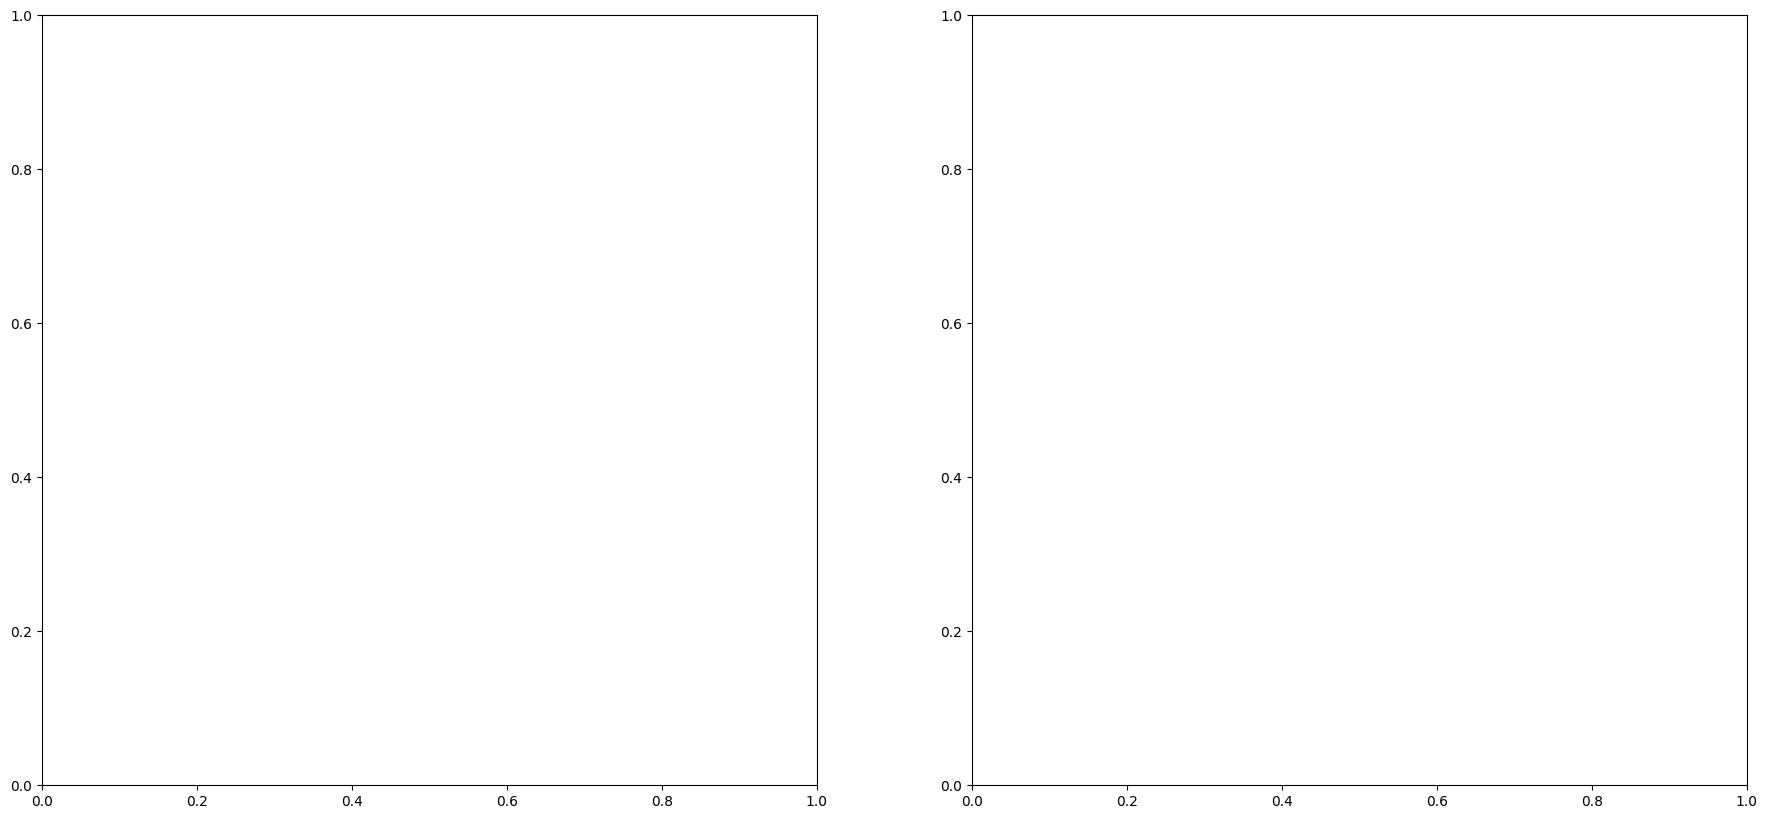

In [2]:
clahe_img_list = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax[0].imshow(masked_img, cmap="gray")
clahe_img = clahe(masked_img)
clahe_img_list.append(clahe_img)
ax[1].imshow(clahe_img, cmap="gray")

In [2]:
class CSAWS(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __combined_mask(self, img_name):
        img_name = img_name.split('.')[0]
        mask_path = os.path.join(self.mask_dir, img_name.split('_')[0])
        mask_nipple_name = os.path.join(mask_path, img_name + "_nipple.png")
        mask_pectoral_muscle_name = os.path.join(mask_path, img_name + "_pectoral_muscle.png")

        mask_nipple = Image.open(mask_nipple_name).convert('L')
        mask_pectoral_muscle = Image.open(mask_pectoral_muscle_name).convert('L')

        mask_nipple = np.array(mask_nipple) > 0
        mask_pectoral_muscle = np.array(mask_pectoral_muscle) > 0

        
        h, w = mask_nipple.shape
        combined_mask = np.zeros((h, w, 3), dtype=np.uint8)  # 3 classes

        combined_mask[:, :, 0] = ~(mask_nipple | mask_pectoral_muscle)
        combined_mask[:, :, 1] = mask_nipple
        combined_mask[:, :, 2] = mask_pectoral_muscle
        combined_mask = combined_mask.astype(np.float32)

        return combined_mask       

    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img = cv2.imread(os.path.join(self.img_dir, img_name), cv2.IMREAD_GRAYSCALE)
        mask = self.__combined_mask(img_name)
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask.argmax(dim=2).squeeze()

In [3]:
trainsize = 512
# flip
# randomrotate90

train_transform = A.Compose([
    A.Resize(trainsize, trainsize),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean = (0.485), std = (0.229)),
    A.ToRGB(),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(trainsize, trainsize),
    A.Normalize(mean = (0.485), std = (0.229)),
    A.ToRGB(),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(trainsize, trainsize),
    A.Normalize(mean = (0.485), std = (0.229)),
    A.ToRGB(),
    ToTensorV2()
])

In [4]:
train_dir = "/home/phanthc/Chi/Data/CSAW-S/CSAWS_Sample/processed_images"
train_mask_dir = "/home/phanthc/Chi/Data/CSAW-S/CSAWS_Sample/anonymized_dataset"
val_dir = "/home/phanthc/Chi/Data/CSAW-S/CSAWS_Sample/val_data/original_images"
val_mask_dir = "/home/phanthc/Chi/Data/CSAW-S/CSAWS_Sample/val_data/annotator_1"
test_dir = "/home/phanthc/Chi/Data/CSAW-S/CSAWS_Sample/test_data/original_images"
test_mask_dir= "/home/phanthc/Chi/Data/CSAW-S/CSAWS_Sample/test_data/annotator_1"

In [5]:
train_dataset = CSAWS(train_dir, train_mask_dir, transform=train_transform)
val_dataset = CSAWS(val_dir, val_mask_dir, transform=val_transform)
test_dataset = CSAWS(test_dir, test_mask_dir, transform=test_transform)

In [6]:
print(len(train_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

11
torch.Size([3, 512, 512]) torch.Size([512, 512])


In [8]:
print(len(val_dataset))
print(val_dataset[0][0].shape, val_dataset[0][1].shape)

3
torch.Size([3, 512, 512]) torch.Size([512, 512])


In [9]:
print(len(test_dataset))
print(test_dataset[0][0].shape, test_dataset[0][1].shape)

5
torch.Size([3, 512, 512]) torch.Size([512, 512])


In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


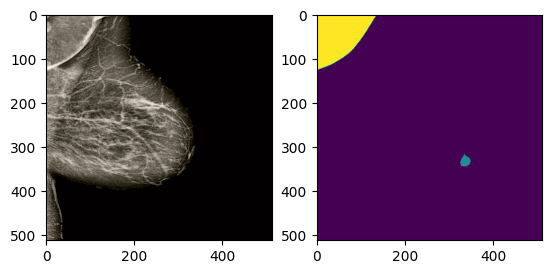

tensor([0, 1, 2])


In [11]:
img, mask = train_dataset[1]
plt.subplot(1, 2, 1)
img = unorm(img).permute(1, 2, 0)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()
print(mask.unique())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


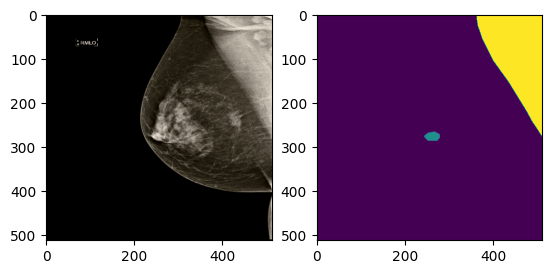

tensor([0, 1, 2])


In [26]:
img, mask = val_dataset[1]
plt.subplot(1, 2, 1)
img = unorm(img).permute(1, 2, 0)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()
print(mask.unique())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


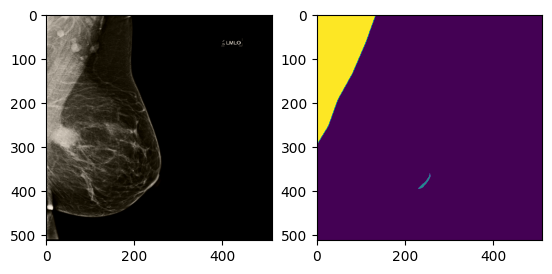

tensor([0, 1, 2])


In [27]:
img, mask = test_dataset[1]
plt.subplot(1, 2, 1)
img = unorm(img).permute(1, 2, 0)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()
print(mask.unique())

In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target 

In [34]:
!python mmsegmentation/tools/model_converters/mit2mmseg.py /home/phanthc/Chi/Code/CSAWS-Segment/pretrained/mit_b4.pth /home/phanthc/Chi/Code/CSAWS-Segment/pretrained/mit_b4_mmseg.pth

04/16 12:33:19 - mmengine - INFO - Loads checkpoint by local backend from path: /home/phanthc/Chi/Code/CSAWS-Segment/pretrained/mit_b4.pth


In [14]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#load data
batch_size = 1
n_workers = os.cpu_count()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model settings
norm_cfg = dict(type='BN', requires_grad=True)
model_cfg = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 8, 27, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg = dict(type="Pretrained", checkpoint="pretrained/mit_b4_mmseg.pth")),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

import mmcv
from mmseg.models import build_segmentor
model = build_segmentor(model_cfg).to(device)
model.init_weights()

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
n_eps = 100

#meter
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()




cuda


/home/phanthc/miniforge3/envs/csaws-segment/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/phanthc/miniforge3/envs/csaws-segment/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/16 14:52:59 - mmengine - INFO - load model from: pretrained/mit_b4_mmseg.pth
04/16 14:52:59 - mmengine - INFO - Loads checkpoint by local backend from path: pretrained/mit_b4_mmseg.pth
04/16 14:52:59 - mmengine - INFO - 
backbone.layers.0.0.projection.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from pretrained/mit_b4_mmseg.pth 
 
04/16 14:52:59 - mmengine - INFO - 
backbone.layers.0.0.projection.bias - torch.Size([64]): 
PretrainedInit: load from pretrained/mit_b4_mmseg.pth 
 
04/16 14:52:59 - mmengine - INFO - 
backbone.layers.0.0.norm.weight - torch.Size([64]): 
PretrainedInit: load from pretrained/mit_b4_mmseg.pth 
 
04/16 14:52:59 - mmengine - INFO - 
backbone.layers.0.0.norm.bias - torch.Size([64]): 
PretrainedInit: load from pretrained/mit_b4_mmseg.pth 
 
04/16 14:52:59 - mmengine - INFO - 
backbone.layers.0.1.0.norm1.weight - torch.Size([64]): 
PretrainedInit: load from pretrained/mit_b4_mmseg.pth 
 
04/16 14:52:59 - mmengine - INFO - 
backbone.layers.0.1.0.norm

In [36]:
!pip install openmim
!mim install mmsegmentation

  Using cached openmim-0.3.9-py2.py3-none-any.whl.metadata (16 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached model_index-0.1.11-py3-none-any.whl.metadata (3.9 kB)
  Using cached opendatalab-0.0.10-py3-none-any.whl.metadata (6.4 kB)
  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached ordered_set-4.1.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pycryptodome-3.20.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached oss2-2.17.0-py3-none-any.whl
  Using cached pytz-2023.4-py2.py3-none-any.whl.metadata (22 kB)
  Using cached requests-2.28.2-py3-none-any.whl.metadata (4.6 kB)
  Using cache

In [40]:
!pip install ftfy
!pip install regex

  Using cached regex-2023.12.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached regex-2023.12.25-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (777 kB)


In [15]:
for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x) #(B, C, H, W)
        y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 3)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

        mIoU = torch.mean(iou_class) #mean vector 21D
        mDice = torch.mean(dice_class) #mean vector 21D

    print("EP {}, current_lr = {} , train loss = {} IoU = {}, dice = {}".format(ep, scheduler.get_last_lr(), train_loss_meter.avg, mIoU, mDice))
    scheduler.step()
    
    if ep >= 95:
        torch.save(model.state_dict(), "modelSegFormer_ep_{}.pth".format(ep))

100%|██████████| 11/11 [00:05<00:00,  2.19it/s]


EP 1, current_lr = [0.0001] , train loss = 1.063113965771415 IoU = 0.028481053188443184, dice = 0.039381299167871475


100%|██████████| 11/11 [00:03<00:00,  3.48it/s]


EP 2, current_lr = [0.0001] , train loss = 0.893227295442061 IoU = 0.05917254090309143, dice = 0.06851285696029663


100%|██████████| 11/11 [00:03<00:00,  3.50it/s]


EP 3, current_lr = [0.0001] , train loss = 0.7586543722586199 IoU = 0.06729492545127869, dice = 0.07625062763690948


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 4, current_lr = [0.0001] , train loss = 0.6557705077258024 IoU = 0.07962868362665176, dice = 0.08602620661258698


100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


EP 5, current_lr = [0.0001] , train loss = 0.569577997381037 IoU = 0.07664652168750763, dice = 0.08389775454998016


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


EP 6, current_lr = [0.0001] , train loss = 0.4899534826928919 IoU = 0.08135944604873657, dice = 0.08720169961452484


100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


EP 7, current_lr = [0.0001] , train loss = 0.4178022931922566 IoU = 0.08418813347816467, dice = 0.08904269337654114


100%|██████████| 11/11 [00:03<00:00,  3.23it/s]


EP 8, current_lr = [0.0001] , train loss = 0.3510825715281747 IoU = 0.0872533842921257, dice = 0.09090778231620789


100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


EP 9, current_lr = [0.0001] , train loss = 0.3042913458564065 IoU = 0.08821768313646317, dice = 0.09147005528211594


100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


EP 10, current_lr = [0.0001] , train loss = 0.26194820756262 IoU = 0.09036685526371002, dice = 0.0926816463470459


100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


EP 11, current_lr = [0.0001] , train loss = 0.2247152951630679 IoU = 0.089999258518219, dice = 0.09247836470603943


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 12, current_lr = [0.0001] , train loss = 0.20089816776188937 IoU = 0.08994428813457489, dice = 0.09244763851165771


100%|██████████| 11/11 [00:03<00:00,  3.21it/s]


EP 13, current_lr = [0.0001] , train loss = 0.18163323808800091 IoU = 0.0879012793302536, dice = 0.09128663688898087


100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


EP 14, current_lr = [0.0001] , train loss = 0.17294313284483823 IoU = 0.08612450957298279, dice = 0.09023484587669373


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


EP 15, current_lr = [0.0001] , train loss = 0.15582373467358676 IoU = 0.08759032934904099, dice = 0.09110604226589203


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 16, current_lr = [0.0001] , train loss = 0.1458123434673656 IoU = 0.08372912555932999, dice = 0.08874618262052536


100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


EP 17, current_lr = [0.0001] , train loss = 0.12484104999087074 IoU = 0.0899079442024231, dice = 0.09242770820856094


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 18, current_lr = [0.0001] , train loss = 0.11955773085355759 IoU = 0.08973696082830429, dice = 0.0923319086432457


100%|██████████| 11/11 [00:03<00:00,  3.21it/s]


EP 19, current_lr = [0.0001] , train loss = 0.10175113447687843 IoU = 0.09150142222642899, dice = 0.09330001473426819


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


EP 20, current_lr = [0.0001] , train loss = 0.0933984558690678 IoU = 0.0914338231086731, dice = 0.09326359629631042


100%|██████████| 11/11 [00:03<00:00,  3.37it/s]


EP 21, current_lr = [5e-05] , train loss = 0.092112543230707 IoU = 0.0920221284031868, dice = 0.09357898682355881


100%|██████████| 11/11 [00:03<00:00,  3.37it/s]


EP 22, current_lr = [5e-05] , train loss = 0.0884413556619124 IoU = 0.09206967055797577, dice = 0.09360430389642715


100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


EP 23, current_lr = [5e-05] , train loss = 0.07939734648574483 IoU = 0.09194006770849228, dice = 0.09353519976139069


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


EP 24, current_lr = [5e-05] , train loss = 0.07793305204673247 IoU = 0.0925007238984108, dice = 0.09383277595043182


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


EP 25, current_lr = [5e-05] , train loss = 0.07677194950255481 IoU = 0.09300316870212555, dice = 0.09409656375646591


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 26, current_lr = [5e-05] , train loss = 0.07712428136305376 IoU = 0.09227218478918076, dice = 0.09371189028024673


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 27, current_lr = [5e-05] , train loss = 0.07234233753247694 IoU = 0.09255608171224594, dice = 0.09386196732521057


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


EP 28, current_lr = [5e-05] , train loss = 0.06977388567545197 IoU = 0.09261447191238403, dice = 0.09389273822307587


100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


EP 29, current_lr = [5e-05] , train loss = 0.06870715320110321 IoU = 0.09225422143936157, dice = 0.09370236098766327


100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


EP 30, current_lr = [5e-05] , train loss = 0.06412399357015436 IoU = 0.09284910559654236, dice = 0.09401597827672958


100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


EP 31, current_lr = [5e-05] , train loss = 0.0618169094351205 IoU = 0.09282257407903671, dice = 0.09400205314159393


100%|██████████| 11/11 [00:03<00:00,  3.23it/s]


EP 32, current_lr = [5e-05] , train loss = 0.05998517031019384 IoU = 0.09296397864818573, dice = 0.09407608211040497


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


EP 33, current_lr = [5e-05] , train loss = 0.05915238200263544 IoU = 0.09301802515983582, dice = 0.0941043272614479


100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


EP 34, current_lr = [5e-05] , train loss = 0.060469665649262344 IoU = 0.09290274977684021, dice = 0.09404406696557999


100%|██████████| 11/11 [00:03<00:00,  3.27it/s]


EP 35, current_lr = [5e-05] , train loss = 0.05714967711405321 IoU = 0.09270081669092178, dice = 0.09393812716007233


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 36, current_lr = [5e-05] , train loss = 0.054002909497781235 IoU = 0.09316142648458481, dice = 0.09417910128831863


100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


EP 37, current_lr = [5e-05] , train loss = 0.05624252490021966 IoU = 0.09316235780715942, dice = 0.09417958557605743


100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


EP 38, current_lr = [5e-05] , train loss = 0.05237495696002787 IoU = 0.09274610877037048, dice = 0.0939619243144989


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 39, current_lr = [5e-05] , train loss = 0.050258823077787056 IoU = 0.09348372370004654, dice = 0.09434636682271957


100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


EP 40, current_lr = [5e-05] , train loss = 0.04813493144783107 IoU = 0.0934460312128067, dice = 0.09432685375213623


100%|██████████| 11/11 [00:03<00:00,  3.27it/s]


EP 41, current_lr = [2.5e-05] , train loss = 0.04918930984356187 IoU = 0.09327209740877151, dice = 0.09423665702342987


100%|██████████| 11/11 [00:03<00:00,  3.11it/s]


EP 42, current_lr = [2.5e-05] , train loss = 0.04562683606689626 IoU = 0.09343618899583817, dice = 0.09432176500558853


100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


EP 43, current_lr = [2.5e-05] , train loss = 0.049673614515499634 IoU = 0.09337865561246872, dice = 0.09429196268320084


100%|██████████| 11/11 [00:03<00:00,  3.23it/s]


EP 44, current_lr = [2.5e-05] , train loss = 0.046715494245290756 IoU = 0.09351977705955505, dice = 0.09436500072479248


100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


EP 45, current_lr = [2.5e-05] , train loss = 0.04634942283684557 IoU = 0.09313461929559708, dice = 0.09416513890028


100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


EP 46, current_lr = [2.5e-05] , train loss = 0.045247063718058846 IoU = 0.09352155774831772, dice = 0.0943659245967865


100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


EP 47, current_lr = [2.5e-05] , train loss = 0.04486173052679409 IoU = 0.09371732920408249, dice = 0.0944669172167778


100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


EP 48, current_lr = [2.5e-05] , train loss = 0.04616524075919932 IoU = 0.09339679032564163, dice = 0.09430135041475296


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 49, current_lr = [2.5e-05] , train loss = 0.0433224080638452 IoU = 0.0936860665678978, dice = 0.09445081651210785


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 50, current_lr = [2.5e-05] , train loss = 0.043789242817596954 IoU = 0.09303224831819534, dice = 0.09411174058914185


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 51, current_lr = [2.5e-05] , train loss = 0.04028795033015988 IoU = 0.09390153735876083, dice = 0.09456158429384232


100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


EP 52, current_lr = [2.5e-05] , train loss = 0.04117252339016308 IoU = 0.09331025928258896, dice = 0.0942564606666565


100%|██████████| 11/11 [00:03<00:00,  3.27it/s]


EP 53, current_lr = [2.5e-05] , train loss = 0.040679019621827385 IoU = 0.09345223009586334, dice = 0.0943300649523735


100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


EP 54, current_lr = [2.5e-05] , train loss = 0.04060179977254434 IoU = 0.09375030547380447, dice = 0.0944838896393776


100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


EP 55, current_lr = [2.5e-05] , train loss = 0.039415226741270584 IoU = 0.09364485740661621, dice = 0.09442957490682602


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 56, current_lr = [2.5e-05] , train loss = 0.04084316539493474 IoU = 0.09377605468034744, dice = 0.09449712932109833


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


EP 57, current_lr = [2.5e-05] , train loss = 0.038706609471277756 IoU = 0.09388361871242523, dice = 0.09455239027738571


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


EP 58, current_lr = [2.5e-05] , train loss = 0.039305376735600556 IoU = 0.09362344443798065, dice = 0.09441853314638138


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


EP 59, current_lr = [2.5e-05] , train loss = 0.038772084157575264 IoU = 0.09369713068008423, dice = 0.0944565162062645


100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


EP 60, current_lr = [2.5e-05] , train loss = 0.037196872755885124 IoU = 0.0938275009393692, dice = 0.09452357888221741


100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


EP 61, current_lr = [1.25e-05] , train loss = 0.03779536519538273 IoU = 0.09362393617630005, dice = 0.09441877901554108


100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


EP 62, current_lr = [1.25e-05] , train loss = 0.03642114996910095 IoU = 0.09371986985206604, dice = 0.09446822106838226


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


EP 63, current_lr = [1.25e-05] , train loss = 0.036617542024363174 IoU = 0.09347711503505707, dice = 0.09434293955564499


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 64, current_lr = [1.25e-05] , train loss = 0.03583458269184286 IoU = 0.0938810259103775, dice = 0.09455105662345886


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


EP 65, current_lr = [1.25e-05] , train loss = 0.03578083877536384 IoU = 0.09387969970703125, dice = 0.09455037117004395


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


EP 66, current_lr = [1.25e-05] , train loss = 0.03665047325193882 IoU = 0.0938948467373848, dice = 0.09455814957618713


100%|██████████| 11/11 [00:03<00:00,  3.38it/s]


EP 67, current_lr = [1.25e-05] , train loss = 0.03696195002306591 IoU = 0.09355627745389938, dice = 0.0943838581442833


100%|██████████| 11/11 [00:03<00:00,  3.38it/s]


EP 68, current_lr = [1.25e-05] , train loss = 0.03644715605134314 IoU = 0.0939200147986412, dice = 0.0945710614323616


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


EP 69, current_lr = [1.25e-05] , train loss = 0.03506137092005123 IoU = 0.09350430220365524, dice = 0.09435700625181198


100%|██████████| 11/11 [00:03<00:00,  3.41it/s]


EP 70, current_lr = [1.25e-05] , train loss = 0.03657900169491768 IoU = 0.09368468821048737, dice = 0.09445010125637054


100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


EP 71, current_lr = [1.25e-05] , train loss = 0.035828195681626145 IoU = 0.09391576051712036, dice = 0.0945688784122467


100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


EP 72, current_lr = [1.25e-05] , train loss = 0.03510865484448997 IoU = 0.09368731826543808, dice = 0.09445146471261978


100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


EP 73, current_lr = [1.25e-05] , train loss = 0.034547855061563576 IoU = 0.09376851469278336, dice = 0.09449325501918793


100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


EP 74, current_lr = [1.25e-05] , train loss = 0.033588104458017784 IoU = 0.09396450221538544, dice = 0.09459385275840759


100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


EP 75, current_lr = [1.25e-05] , train loss = 0.03407332707535137 IoU = 0.09227044135332108, dice = 0.09371094405651093


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


EP 76, current_lr = [1.25e-05] , train loss = 0.035522635179487144 IoU = 0.0938296765089035, dice = 0.09452468901872635


100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


EP 77, current_lr = [1.25e-05] , train loss = 0.03479381345889785 IoU = 0.09358854591846466, dice = 0.09440051764249802


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


EP 78, current_lr = [1.25e-05] , train loss = 0.032916062088175255 IoU = 0.09378926455974579, dice = 0.09450392425060272


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


EP 79, current_lr = [1.25e-05] , train loss = 0.033574798398397186 IoU = 0.09390809386968613, dice = 0.09456493705511093


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


EP 80, current_lr = [1.25e-05] , train loss = 0.03196067701686512 IoU = 0.09394140541553497, dice = 0.09458202868700027


100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


EP 81, current_lr = [6.25e-06] , train loss = 0.03283347934484482 IoU = 0.09366386383771896, dice = 0.09443937242031097


100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


EP 82, current_lr = [6.25e-06] , train loss = 0.033406034111976624 IoU = 0.09370860457420349, dice = 0.09446242451667786


100%|██████████| 11/11 [00:03<00:00,  3.19it/s]


EP 83, current_lr = [6.25e-06] , train loss = 0.03380913321267475 IoU = 0.0939144417643547, dice = 0.09456820040941238


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


EP 84, current_lr = [6.25e-06] , train loss = 0.032260161909190094 IoU = 0.09408111870288849, dice = 0.09465353190898895


100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


EP 85, current_lr = [6.25e-06] , train loss = 0.031164368614554405 IoU = 0.09380321949720383, dice = 0.09451109915971756


100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


EP 86, current_lr = [6.25e-06] , train loss = 0.0322953039272265 IoU = 0.09398487955331802, dice = 0.09460429102182388


100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


EP 87, current_lr = [6.25e-06] , train loss = 0.03162775205617601 IoU = 0.09388766437768936, dice = 0.09455446153879166


100%|██████████| 11/11 [00:03<00:00,  3.25it/s]


EP 88, current_lr = [6.25e-06] , train loss = 0.031560483473268425 IoU = 0.0940009206533432, dice = 0.09461250901222229


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


EP 89, current_lr = [6.25e-06] , train loss = 0.031053325669331985 IoU = 0.09402818232774734, dice = 0.09462645649909973


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


EP 90, current_lr = [6.25e-06] , train loss = 0.032440751791000366 IoU = 0.09380108118057251, dice = 0.09450999647378922


100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


EP 91, current_lr = [6.25e-06] , train loss = 0.03187756511298093 IoU = 0.09390420466661453, dice = 0.09456295520067215


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


EP 92, current_lr = [6.25e-06] , train loss = 0.030963144519112328 IoU = 0.09392376244068146, dice = 0.09457297623157501


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


EP 93, current_lr = [6.25e-06] , train loss = 0.03135406005788933 IoU = 0.09386337548494339, dice = 0.094541996717453


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


EP 94, current_lr = [6.25e-06] , train loss = 0.03002007474953478 IoU = 0.09389611333608627, dice = 0.09455879777669907


100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


EP 95, current_lr = [6.25e-06] , train loss = 0.031498752534389496 IoU = 0.0937865599989891, dice = 0.0945025384426117


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


EP 96, current_lr = [6.25e-06] , train loss = 0.032841382548213005 IoU = 0.09387963265180588, dice = 0.09455034136772156


100%|██████████| 11/11 [00:03<00:00,  3.38it/s]


EP 97, current_lr = [6.25e-06] , train loss = 0.02965365993705663 IoU = 0.0938846617937088, dice = 0.09455292671918869


100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


EP 98, current_lr = [6.25e-06] , train loss = 0.031404698436910454 IoU = 0.0939788818359375, dice = 0.09460122138261795


100%|██████████| 11/11 [00:03<00:00,  3.38it/s]


EP 99, current_lr = [6.25e-06] , train loss = 0.029599245298992504 IoU = 0.09395284205675125, dice = 0.09458788484334946


100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


EP 100, current_lr = [6.25e-06] , train loss = 0.03094071454622529 IoU = 0.09404348582029343, dice = 0.0946342870593071


In [16]:
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(valloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x)
        y_hat = F.interpolate(y_hat, size=y.shape[1], mode="bilinear")
        y_hat = y_hat.squeeze(1)
        y_hat_mask = y_hat.argmax(dim=1)
        
        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, 21)
        test_intersection_meter.update(intersection)
        test_union_meter.update(union)
        test_target_meter.update(target)
        
    val_iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    val_dice_class = 2*test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    val_mIoU = torch.mean(iou_class)
    val_mDice = torch.mean(dice_class)
        
print("TEST: IoU = {}, dice = {}".format(mIoU, mDice))

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

TEST: IoU = 0.09404348582029343, dice = 0.0946342870593071


In [ ]:
import torch
from tqdm import tqdm
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def train_one_epoch(model, device, trainloader, optimizer, criterion, meters, scheduler):
    model.train()
    train_loss_meter, intersection_meter, union_meter, target_meter = meters
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        x, y = x.to(device).float(), y.to(device).long()
        optimizer.zero_grad()
        y_hat = model(x)
        y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss_meter.update(loss.item(), n=x.size(0))
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    scheduler.step()
    return train_loss_meter.avg

def validate(model, device, valloader, criterion, meters):
    model.eval()
    validation_loss_meter, intersection_meter, union_meter, target_meter = meters
    validation_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()

    with torch.no_grad():
        for x, y in tqdm(valloader):
            x, y = x.to(device).float(), y.to(device).long()
            y_hat = model(x)
            y_hat = F.interpolate(y_hat, size=y.shape[1], mode="bilinear")
            loss = criterion(y_hat, y)

            validation_loss_meter.update(loss.item(), n=x.size(0))
            y_hat_mask = y_hat.argmax(dim=1)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    val_iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    val_dice = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
    val_mIoU = torch.mean(val_iou)
    val_mDice = torch.mean(val_dice)
    return validation_loss_meter.avg, val_mIoU, val_mDice

def train_model(model, device, trainloader, valloader, optimizer, criterion, scheduler, n_epochs, early_stopping_patience):
    best_val_loss = float('inf')
    no_improve_epochs = 0

    # Initialize meters
    train_loss_meter = AverageMeter()
    train_intersection_meter = AverageMeter()
    train_union_meter = AverageMeter()
    train_target_meter = AverageMeter()

    val_loss_meter = AverageMeter()
    val_intersection_meter = AverageMeter()
    val_union_meter = AverageMeter()
    val_target_meter = AverageMeter()

    train_meters = (train_loss_meter, train_intersection_meter, train_union_meter, train_target_meter)
    val_meters = (val_loss_meter, val_intersection_meter, val_union_meter, val_target_meter)

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, device, trainloader, optimizer, criterion, train_meters, scheduler)
        val_loss, val_mIoU, val_mDice = validate(model, device, valloader, criterion, val_meters)

        logging.info(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Val IoU: {val_mIoU}, Val Dice: {val_mDice}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), "best_model.pth")
            logging.info("Saved new best model")
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_patience:
            logging.info("Early stopping triggered")
            break

        if epoch % 10 == 0 or epoch == n_epochs:
            torch.save(model.state_dict(), f"model_checkpoint_epoch_{epoch}.pth")

    return model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 2]
(512, 512)


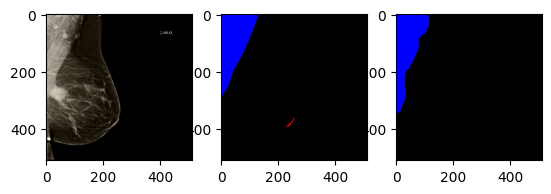

In [17]:
#predict
CUSTOM_COLORMAP = [
    (0, 0, 0),  # Background
    (255, 0, 0),  # Nipple
    (0, 0, 255)  # Pectoral muscle
]

import random
id = random.randint(0, 4)
with torch.no_grad():
    model.eval()
    x, y = test_dataset.__getitem__(id)
    y_predict = F.interpolate(model(x.unsqueeze(0).to(device)), size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()
    print(np.unique(y_predict))
    print(y_predict.shape)
    color_mask_predict = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(CUSTOM_COLORMAP):
        color_mask_predict[y_predict==i] = np.array(color)
    color_mask = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(CUSTOM_COLORMAP):
        color_mask[y==i] = np.array(color)
    plt.subplot(1,3,1)
    plt.imshow(unorm(x).permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.subplot(1,3,3)
    plt.imshow(color_mask_predict)
    plt.show()

In [18]:
model.eval()

# Initialize meters for tracking metrics
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()

# Evaluate the model on the test set without gradient computation
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()

        # Model prediction
        y_hat = model(x)
        y_hat = F.interpolate(y_hat, size=y.shape[1:], mode="bilinear")  # Ensure size matches the target
        y_hat = y_hat.squeeze(1)  # Adjust depending on your output dimensions
        y_hat_mask = y_hat.argmax(dim=1)

        # Compute intersection and union for IoU calculation
        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, 21)  # Change number of classes if different
        test_intersection_meter.update(intersection, n)
        test_union_meter.update(union, n)
        test_target_meter.update(target, n)

    # Calculate class-wise and mean IoU and Dice scores
    test_iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    test_dice_class = 2 * test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    test_mIoU = torch.mean(test_iou_class)
    test_mDice = torch.mean(test_dice_class)

# Output the metrics for the test set
print("TEST: IoU = {}, Dice = {}".format(test_mIoU, test_mDice))

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

TEST: IoU = 0.08767277002334595, Dice = 0.09116905182600021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


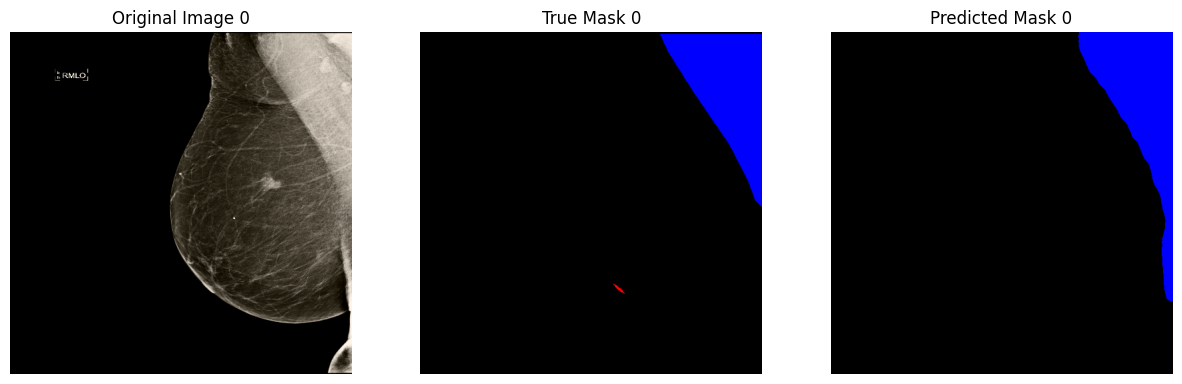

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


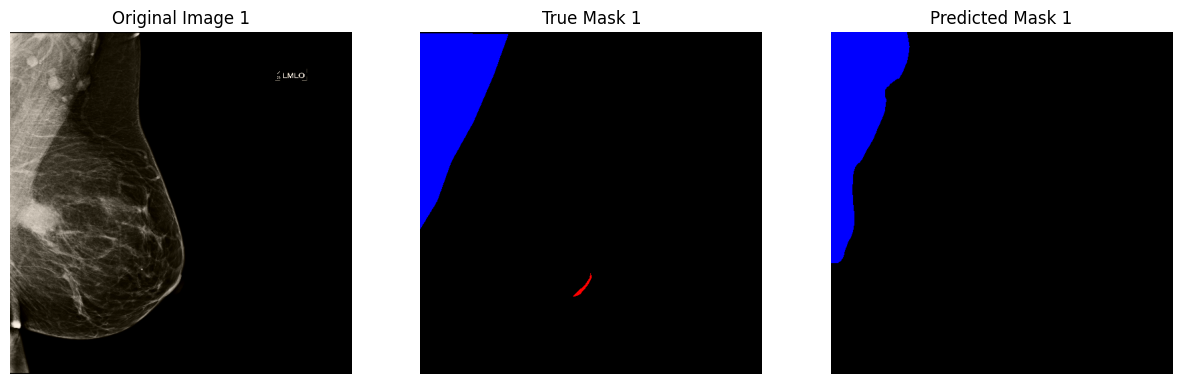

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


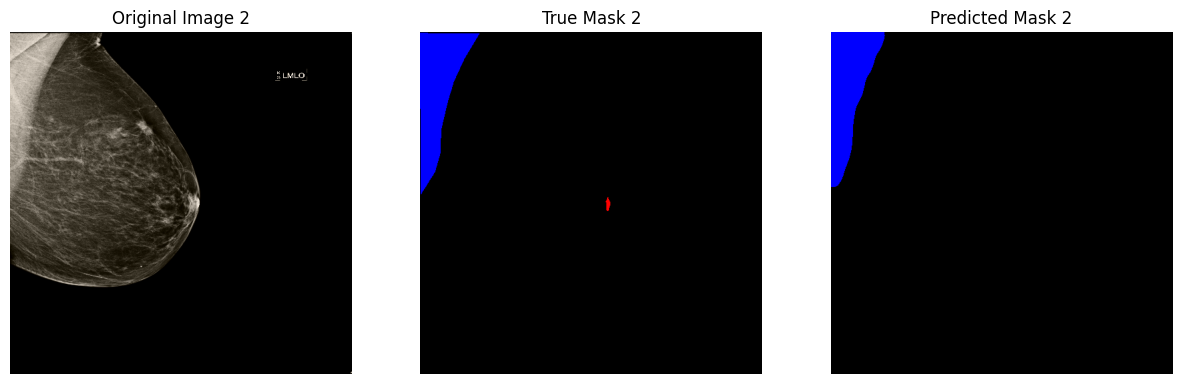

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


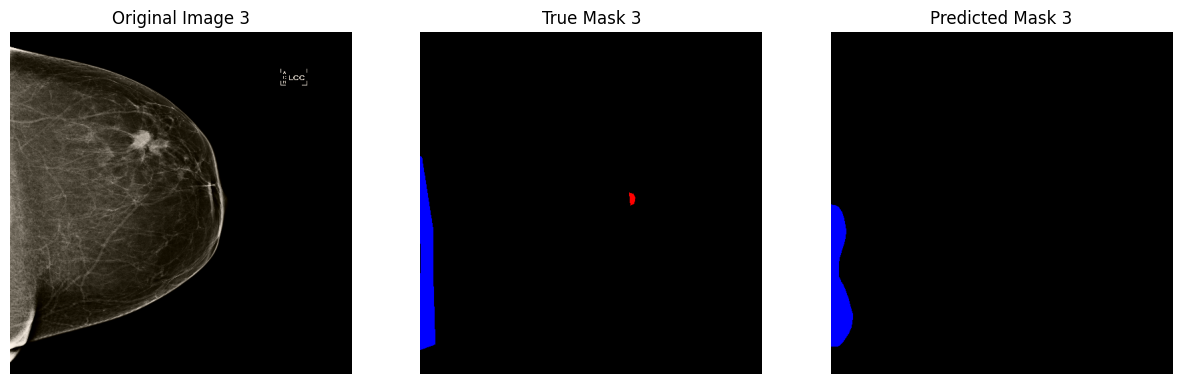

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


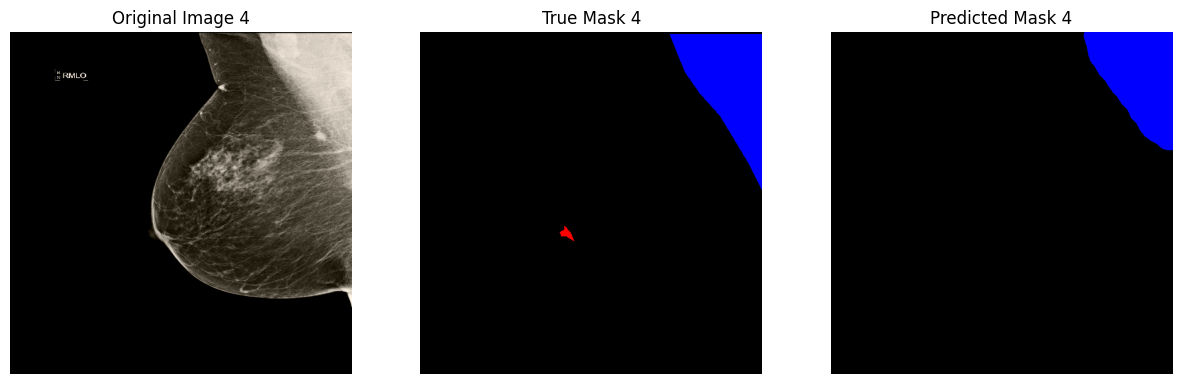

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Custom colormap definition
CUSTOM_COLORMAP = [
    (0, 0, 0),  # Background
    (255, 0, 0),  # Nipple
    (0, 0, 255)  # Pectoral muscle
]

# Ensure the model is in evaluation mode and we're not tracking gradients
with torch.no_grad():
    model.eval()

    # Loop through the test dataset
    for id in range(len(test_dataset)):
        x, y = test_dataset[id]

        # Assume your test_dataset returns tensors already suitable for input
        # If your images are not 3-channel, you may need to adjust this
        y_predict = F.interpolate(model(x.unsqueeze(0).to(device)), size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()

        # Create color masks for true and predicted labels
        color_mask_predict = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
        color_mask = np.zeros((*y_predict.shape, 3), dtype=np.uint8)

        for i, color in enumerate(CUSTOM_COLORMAP):
            color_mask_predict[y_predict == i] = np.array(color)
            color_mask[y == i] = np.array(color)

        # Plot original image, true mask, and predicted mask
        plt.figure(figsize=(15, 5))  # Adjust the figure size as necessary
        plt.subplot(1, 3, 1)
        plt.imshow(unorm(x).permute(1, 2, 0).cpu(), cmap='gray')  # Assuming x is normalized and permuted correctly
        plt.title(f'Original Image {id}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(color_mask)
        plt.title(f'True Mask {id}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(color_mask_predict)
        plt.title(f'Predicted Mask {id}')
        plt.axis('off')

        plt.show()
